In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# === Load train dataset only === #
project = Path.cwd()
target_folder = project / "0 - data"
train_df = pd.read_excel(target_folder / "train_clean.xlsx", sheet_name="Sheet1")

In [ ]:
# === Define target + features === #
target_col = "Automation Suitable"
drop_cols = ["Task ID", "Task Name"]
drop_cols = [c for c in drop_cols if c in train_df.columns]

X_train = train_df.drop(columns=[target_col] + drop_cols)

# Convert target: Yes=1, No=0
y_train = train_df[target_col].map({"Yes": 1, "No": 0})
if y_train.isna().any():
    raise ValueError("Target column contains values other than 'Yes'/'No'.")

cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

In [ ]:
# === Preprocessing (OneHot + passthrough) === #
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

In [ ]:
# === Handle class imbalance === #
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
pos_weight = (neg / pos) if pos > 0 else 1.0

In [ ]:
# === Build Base model (XGBoost) === #
xgb_base_model = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.01,
    subsample=0.6,
    colsample_bytree=0.7,
    objective="binary:logistic",
    scale_pos_weight=pos_weight,
    random_state=42,
    n_jobs=-1
)

base_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_base_model)
])

base_pipeline.fit(X_train, y_train)
print("✅ XGBoost BASE model trained.")

✅ XGBoost BASE model trained.



=== Top 3 for model__n_estimators ===
  600  ->  CV mean=0.8850 (±0.0289)
  400  ->  CV mean=0.8825 (±0.0281)
  300  ->  CV mean=0.8725 (±0.0215)


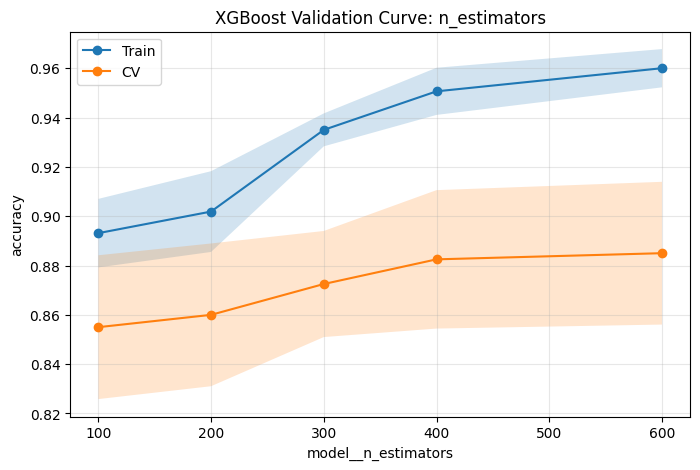


=== Top 3 for model__max_depth ===
  8  ->  CV mean=0.9075 (±0.0170)
  6  ->  CV mean=0.9050 (±0.0170)
  5  ->  CV mean=0.9025 (±0.0146)


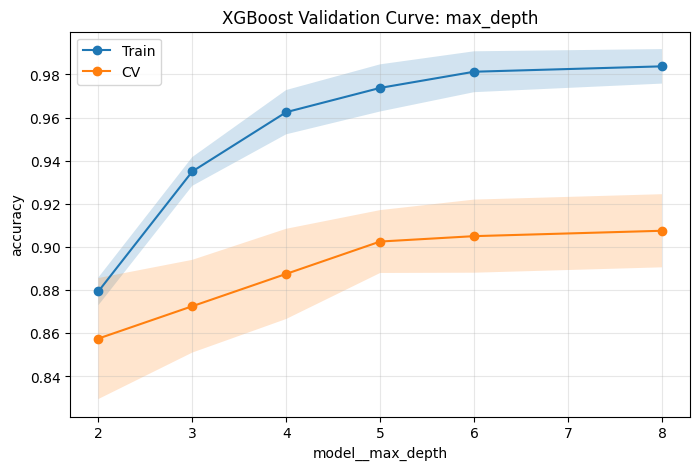


=== Top 3 for model__learning_rate ===
  0.05  ->  CV mean=0.9225 (±0.0242)
  0.1  ->  CV mean=0.9175 (±0.0322)
  0.02  ->  CV mean=0.8900 (±0.0289)


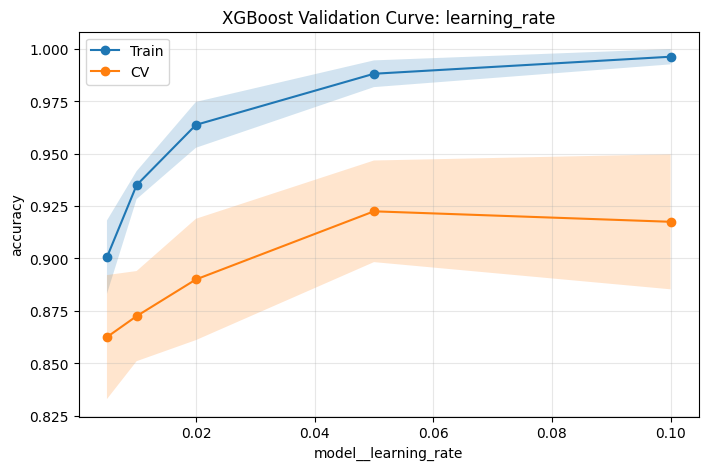


=== Top 3 for model__subsample ===
  1.0  ->  CV mean=0.8900 (±0.0267)
  0.7  ->  CV mean=0.8800 (±0.0257)
  0.8  ->  CV mean=0.8800 (±0.0232)


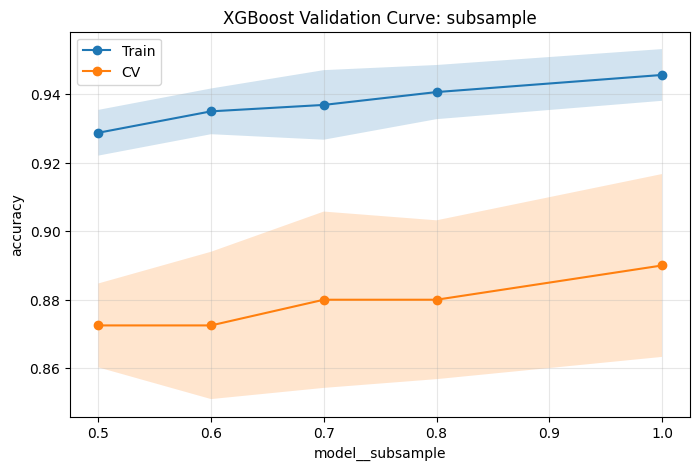


=== Top 3 for model__colsample_bytree ===
  0.5  ->  CV mean=0.8825 (±0.0302)
  0.6  ->  CV mean=0.8775 (±0.0242)
  1.0  ->  CV mean=0.8750 (±0.0237)


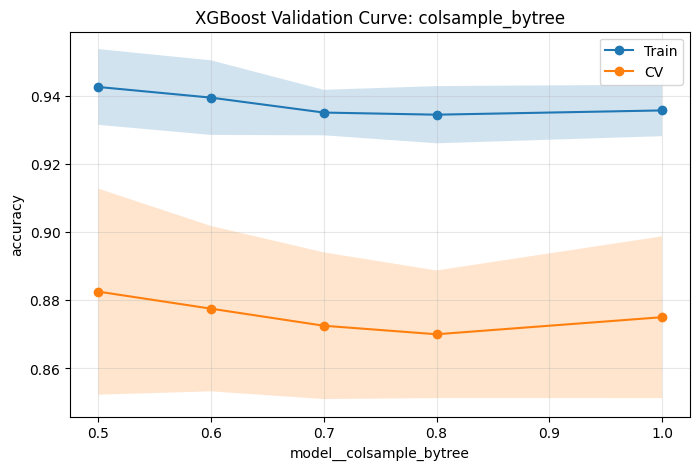

In [ ]:
# === Plot Validation Curve === #
def plot_validation_curve_top3(
    pipeline,
    X_train,
    y_train,
    param_name: str,
    param_range,
    title: str,
    scoring: str = "accuracy",
    cv: int = 5
): # ):
    train_scores, val_scores = validation_curve(
        pipeline,
        X_train,
        y_train,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    top3_idx = np.argsort(val_mean)[-3:][::-1]
    print(f"\n=== Top 3 for {param_name} ===")
    for i in top3_idx:
        print(f"  {param_range[i]}  ->  CV mean={val_mean[i]:.4f} (±{val_std[i]:.4f})")

    plt.figure(figsize=(8, 5))
    plt.plot(param_range, train_mean, marker="o", label="Train")
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(param_range, val_mean, marker="o", label="CV")
    plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

n_estimators_range = [100, 200, 300, 400, 600]

plot_validation_curve_top3(
    base_pipeline,
    X_train, y_train,
    param_name="model__n_estimators",
    param_range=n_estimators_range,
    title="XGBoost Validation Curve: n_estimators",
    scoring="accuracy",
    cv=5
)

max_depth_range = [2, 3, 4, 5, 6, 8]

plot_validation_curve_top3(
    base_pipeline,
    X_train, y_train,
    param_name="model__max_depth",
    param_range=max_depth_range,
    title="XGBoost Validation Curve: max_depth",
    scoring="accuracy",
    cv=5
)

learning_rate_range = [0.005, 0.01, 0.02, 0.05, 0.1]

plot_validation_curve_top3(
    base_pipeline,
    X_train, y_train,
    param_name="model__learning_rate",
    param_range=learning_rate_range,
    title="XGBoost Validation Curve: learning_rate",
    scoring="accuracy",
    cv=5
)

subsample_range = [0.5, 0.6, 0.7, 0.8, 1.0]

plot_validation_curve_top3(
    base_pipeline,
    X_train, y_train,
    param_name="model__subsample",
    param_range=subsample_range,
    title="XGBoost Validation Curve: subsample",
    scoring="accuracy",
    cv=5
)

colsample_range = [0.5, 0.6, 0.7, 0.8, 1.0]

plot_validation_curve_top3(
    base_pipeline,
    X_train, y_train,
    param_name="model__colsample_bytree",
    param_range=colsample_range,
    title="XGBoost Validation Curve: colsample_bytree",
    scoring="accuracy",
    cv=5
)

In [ ]:
# === Hyperparameter tuning (Random Forest) === #
param_distributions = {
    "model__n_estimators": [600, 400, 300],
    "model__max_depth": [8, 6, 5],
    "model__learning_rate": [0.05, 0.1, 0.02],
    "model__subsample": [1.0, 0.7, 0.8],
    "model__colsample_bytree": [0.5, 0.6, 1.0],
}

xgb_search = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True
)

xgb_search.fit(X_train, y_train)

print("\n✅ XGBoost tuning complete.")
print("Best CV Accuracy:", round(xgb_search.best_score_, 4))
print("Best Params:", xgb_search.best_params_)

tuned_pipeline = xgb_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ XGBoost tuning complete.
Best CV Accuracy: 0.9375
Best Params: {'model__subsample': 1.0, 'model__n_estimators': 300, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.5}


In [ ]:
# === Save BASE + TUNED models === #
bundle = {
    "base": base_pipeline,
    "tuned": tuned_pipeline,
    "best_model": tuned_pipeline,
    "best_params": xgb_search.best_params_,
    "best_cv_score": float(xgb_search.best_score_),
    "meta": {
        "model_name": "XGBoost",
        "scoring": "accuracy",
        "cv_folds": 5
    }
}

save_path = "4 - deployment/xgboost_model.pkl"
joblib.dump(bundle, save_path)

print(f"✅ BASE + TUNED XGBoost models saved to: {save_path}")

✅ BASE + TUNED XGBoost models saved to: 4 - deployment/xgboost_model.pkl
